# Examining Brooklyn Data

First, it is necessary to import the packages needed for the analysis and visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import cm as cm
import graphviz
import datetime as dt
import random
# Analysis packages
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns
%matplotlib inline

These are the functions needed for preparing the data when reading the data frame from the csv file. Performing all these functions at the beginning makes the code cleaner and more clearly arranged.
- time_of_day(hour) is dividing the hours of the day in bigger categories that we considered to be interesting when talking about (taxi) traffic.
- checkWeekday(day) checks if a day is a weekday or a weekend day
- calcMinSinceMidnight(dt) calculates the minutes that have passed since midnight from the datetime object
- groupMinSinceMidnight(m) categorizes the minutes since midnight column into larger intervals

In [2]:
# functions needed for data prep

def time_of_day(hour):
    if hour<6:
        return "night"
    elif hour<10:
        return "morning rush"
    elif hour<16:
        return "daytime"
    elif hour<19:
        return "evening_rush"
    else:
        return "night"
    
def checkWeekday(day):
    n = day.isoweekday()
    if n<6:
        return 1
    else:
        return 0
    
def calcMinSinceMidnight(dt):
    min_since_midnight = (dt.hour*60 + dt.minute)
    return min_since_midnight
    
def groupMinSinceMidnight(m):
    for minInt in range(0, 1445, 30):
        if m < minInt:
            return minInt

The steps for importing and preparing the data are the following:
1. Read the csv-file
2.  - As the columns have different names in the pickups and dropoffs datasets, one needs to first find the columns holding the certain values, as it is for example done here finding the 'datetime' column, giving it a more general name such that more generic functions can be performed on it.
    - The values in this datetime columns are then cast to datetime objects (they are strings when they are imported).
    - To order the rows by the datetime, this column is then set as an index. Later, the index is reset in order to make it easier to access the column.
3. A column just containing the date is added.
4. More general latitude and longitude columns are added (see 2. for how to find these)
5. A weekday column is added stating if the day is a weekday or not.
6. A time of day is assigned to each row.
7. The minutes since midnight are calculated and grouped in 30 minutes intervals.
8. The coordinates are collected in one 'location'-column.
9. Unused/ Useless columns are deleted.


In [3]:
def importAndPrepareData(filepath):
    # check if tsv or csv
    impdf = pd.read_csv(filepath, delimiter=',')
    
    datetimeCol = [col for col in impdf.columns if 'datetime' in col]
    impdf['datetime'] = impdf[datetimeCol[0]].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    impdf = impdf.set_index('datetime')
    impdf = impdf.reset_index()
    
    # add a column just containing the date
    impdf['date'] = impdf['datetime'].apply(lambda x: x.date())
    
    # more general lat and lon column names
    lonCol = [col for col in impdf.columns if 'longitude' in col]
    impdf['lon'] = impdf[lonCol[0]]
    latCol = [col for col in impdf.columns if 'latitude' in col]
    impdf['lat'] = impdf[latCol]
    
    # weekday or weekend-day?
    impdf['weekday'] = [checkWeekday(x) for x in impdf['datetime']]
    #TODO: add column saying if this day is an event day or not
    
    # assign time of day to each row
    impdf['time_of_day'] = [time_of_day(x) for x in impdf['datetime'].dt.hour]
    
    # calculate minutes since midnight for each row and group them
    impdf['min_since_midnight'] = [calcMinSinceMidnight(line) for line in impdf['datetime']]
    impdf['min_since_midnight_group'] = [groupMinSinceMidnight(m) for m in impdf['min_since_midnight']]
    
    # collect coordinates in one column
    impdf['location'] = np.nan
    loc = []
    for i in range(len(impdf['lat'].values)):
        loc.append((impdf['lon'].values[i], impdf['lat'].values[i]))
    impdf['location'] = loc
    
    randomCol = [col for col in impdf.columns if 'Unnamed' in col]
    for rc in randomCol: del impdf[rc]
    del impdf['min_since_midnight']

    return impdf

These steps are performed both on the Pickups_Brooklyn_June and the Dropoffs_Brooklyn_June dataset:

In [4]:
pickupDF = importAndPrepareData('Pickups_Brooklyn_June.csv')
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,0.70,2016-06-09,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)"
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)"
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,5.56,2016-06-09,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)"
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,4.20,2016-06-09,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)"
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,2.30,2016-06-09,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)"


In [5]:
dropoffDF = importAndPrepareData('Dropoffs_Brooklyn_June.csv')
dropoffDF.head()

,datetime,dropoff_datetime,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location
0,2016-06-09 21:35:11,2016-06-09 21:35:11,-73.981636,40.670242,1,22.0,4.00,0.0,27.30,1,5.22,2016-06-09,-73.981636,40.670242,1,night,1320,"(-73.9816360474, 40.6702423096)"
1,2016-06-09 21:23:55,2016-06-09 21:23:55,-74.011986,40.703773,1,17.0,3.65,0.0,21.95,1,5.10,2016-06-09,-74.011986,40.703773,1,night,1290,"(-74.0119857788, 40.7037734985)"
2,2016-06-09 21:34:55,2016-06-09 21:34:55,-73.993607,40.666752,1,20.5,2.50,0.0,24.30,1,5.60,2016-06-09,-73.993607,40.666752,1,night,1320,"(-73.9936065674, 40.6667518616)"
3,2016-06-09 21:22:19,2016-06-09 21:22:19,-73.983871,40.693539,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-73.983871,40.693539,1,night,1290,"(-73.98387146, 40.6935386658)"
4,2016-06-09 21:36:56,2016-06-09 21:36:56,-73.989677,40.703846,1,21.0,2.50,0.0,24.80,1,6.01,2016-06-09,-73.989677,40.703846,1,night,1320,"(-73.9896774292, 40.7038459778)"


After importing the data, we decided it would make sense to divide the places into areas. For this purpose, we use the KMeans algorithm to divide the area into evenly distributed clusters. We decided to divide the area into 10 clusters.

The function kmeansOnLocation(df, k=10) takes in a data frame and performs clustering by longitude and latitude. It then adds an extra column of the kmeans_cluster to the dataframe and returns both the modified dataframe and the kmeans object.

To examine how well the clustering is performed, we calculate the silhouette and distortion of the clustering:
The silhouette measures the between-cluster variability, that means, the distance in between the clusters. This should be maximized.
Distortion is a measure for the inter-cluster variability; how far the points in the cluster are away from each other. This should be minimized.

kmeansSilhouette(df) is used to calculate the silhouette. It takes in the data frame and first calculates the pairwise distances between each of the points, then, the silhouette_score function is used to calculate the silhouette.
The distortion can easily be retrieved by the .inertia property of the kmeans object.

In [6]:
def kmeansOnLocation(df, k=10):
    #perform kmeans
    K_allData = k
    k_allData = KMeans(K_allData, )
    k_allData.fit(df[['lat', 'lon']])
    
    # new column in dataframe for location cluster
    df['kmeans_cluster'] = k_allData.labels_
    
    # computing and printing the score of the clustering
    print('------Scores of K-Mean Clustering on dataframe ----------\n'+'silhouette:'+str(kmeansSilhouette(df))+
    '\n'+'distortion: '+str(k_allData.inertia_))
    
    return df, k_allData # returns df with added column from clustering

def kmeansSilhouette(df):
    sampledf = df.sample(n=1000)
    coords = []
    for i in range(len(sampledf['lon'].values)):
        coords.append([sampledf['lon'].values[i], sampledf['lat'].values[i]])
    pwdist = pairwise_distances(coords, metric='manhattan')
    silhouette_avg = silhouette_score(pwdist, sampledf['kmeans_cluster'], metric="precomputed")
    return silhouette_avg

def plotClusters(df, clusterCol='kmeans_cluster'):
    num_colors=len(set(df[clusterCol].values))
    colors=list(mcolors.CSS4_COLORS.keys())  #found this by searching "python color list"
    cluster_colors=random.choices(colors, k=num_colors)
    print(cluster_colors)
    x_=[]
    y_=[]
    c_=[]
    for label, x, y in zip(df[clusterCol].values, df['lon'].values, df['lat'].values):
        if label==-1:
            continue
        x_.append(x)
        y_.append(y)
        c_.append(cluster_colors[label])
        #plt.figure(figsize=(18, 12))
    plt.scatter(x_,y_,s=0.3,c=c_)

In [7]:
pickupDF, kPickup = kmeansOnLocation(pickupDF)

------Scores of K-Mean Clustering on dataframe ----------
silhouette:0.429806187
distortion: 12.1062616811


['seashell', 'mistyrose', 'lightcyan', 'ghostwhite', 'midnightblue', 'wheat', 'slateblue', 'darkslateblue', 'lightsalmon', 'orangered']


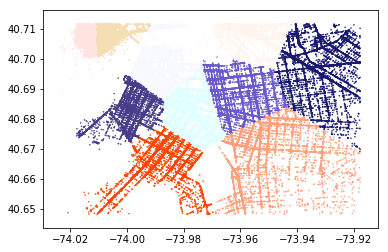

In [8]:
plotClusters(pickupDF)

------Scores of K-Mean Clustering on dataframe ----------
silhouette:0.525428032599
distortion: 39.7600339409
['darkkhaki', 'lightpink', 'mintcream', 'firebrick', 'navajowhite', 'papayawhip', 'mediumturquoise', 'indigo', 'powderblue', 'darkblue']


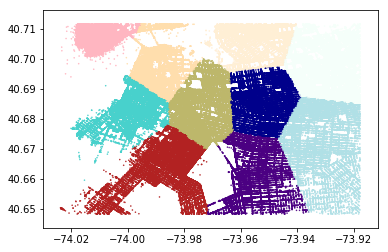

In [9]:
dropoffDF, kdropoff = kmeansOnLocation(dropoffDF)
plotClusters(dropoffDF)

In [10]:
dropoffDF.head()

,datetime,dropoff_datetime,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location,kmeans_cluster
0,2016-06-09 21:35:11,2016-06-09 21:35:11,-73.981636,40.670242,1,22.0,4.00,0.0,27.30,1,5.22,2016-06-09,-73.981636,40.670242,1,night,1320,"(-73.9816360474, 40.6702423096)",3
1,2016-06-09 21:23:55,2016-06-09 21:23:55,-74.011986,40.703773,1,17.0,3.65,0.0,21.95,1,5.10,2016-06-09,-74.011986,40.703773,1,night,1290,"(-74.0119857788, 40.7037734985)",1
2,2016-06-09 21:34:55,2016-06-09 21:34:55,-73.993607,40.666752,1,20.5,2.50,0.0,24.30,1,5.60,2016-06-09,-73.993607,40.666752,1,night,1320,"(-73.9936065674, 40.6667518616)",3
3,2016-06-09 21:22:19,2016-06-09 21:22:19,-73.983871,40.693539,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-73.983871,40.693539,1,night,1290,"(-73.98387146, 40.6935386658)",4
4,2016-06-09 21:36:56,2016-06-09 21:36:56,-73.989677,40.703846,1,21.0,2.50,0.0,24.80,1,6.01,2016-06-09,-73.989677,40.703846,1,night,1320,"(-73.9896774292, 40.7038459778)",4


Another part to examine was the fact how many tips, if any, were given to the taxi drivers.
However, as the dataset contains negative fare_amounts, these should first be removed, as they should not be taken into consideration calculating the fare-tips-ratio.
The tips percentage is calculated, rounded to two decimals and added to the dataframe in another column. The tips_percentages with a value bigger than 1 are removed as it seems quite unlikely that someone would give more than 100 percent of tips.
As it does not make sense to use classes for each percentage of tips given, the percentage of tips given is again classified into a tipClass in steps of 5 percent (using classifyTips(tipPerc))

In [11]:
def calculateTipsPerc(fare, tips):
    return round(tips/fare, 2)

def classifyTips(tipPerc):
    if tipPerc <= 0.05:
        return 1
    elif tipPerc <= 0.1:
        return 2
    elif tipPerc <= 0.15:
        return 3
    elif tipPerc <= 0.2:
        return 4
    elif tipPerc <= 0.25:
        return 5
    elif tipPerc <= 0.3:
        return 6
    elif tipPerc <= 0.35:
        return 7
    else:
        return 8

def tipPreparation(df):
    # preparing data frame for analysis: removing negative and 0 fare_amounts
    df = df[df['fare_amount'] >0]
    
    # creating tip column percentage
    #tipsPerc = []
    #for x, y in zip(df['fare_amount'].values, df['tip_amount'].values):
    #    tipsPerc.append(round(calculateTipsPerc(x, y), 2))
        
    df['tips_perc'] = [round(tips/fare, 2) for fare, tips in zip(df['fare_amount'].values, df['tip_amount'].values)]
        
    # remove tips-perc that were more than 100%
    df = df[df['tips_perc'] <1]
    
    df['tipClass'] = [classifyTips(x) for x in df['tips_perc'].values]
    
    return df


def tipsHistPlot(df, col='tips_perc'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 160000, 20000))
    plt.hist(df[col], bins=20)
    plt.grid()
    plt.show()

In [12]:
pickupDF = tipPreparation(pickupDF)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,...,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location,kmeans_cluster,tips_perc,tipClass
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,...,2016-06-09,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)",1,0.40,8
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,...,2016-06-09,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)",5,0.34,7
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,...,2016-06-09,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)",1,0.21,5
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,...,2016-06-09,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)",5,0.11,3
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,...,2016-06-09,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)",3,0.09,2


Looking at the histogram of the observed percentages of tips given, it becomes more clear why a division into 5 percent steps seems logic in this context:

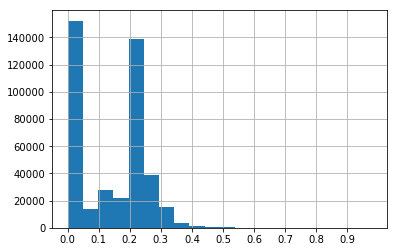

In [14]:
tipsHistPlot(pickupDF)

This is the histogram for the different classes of tips given:

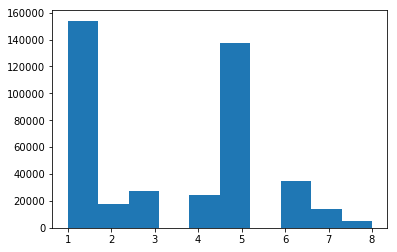

In [15]:
plt.hist(pickupDF['tipClass'])
plt.show()

In [16]:
pickupDF.columns

Index(['datetime', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'passenger_count', 'trip_distance', 'date', 'lon',
       'lat', 'weekday', 'time_of_day', 'min_since_midnight_group', 'location',
       'kmeans_cluster', 'tips_perc', 'tipClass'],
      dtype='object')

To create a model that can predict how much tip will be given, or rather, in which tip-cluster this trip will end up, we decided to use a RandomForestClassifier.
Before getting started, some of the columns need to be transformed into dummy variables as the numerical values would not make sense to use for these.

In [17]:
def createDummyDF(df):
    dummyColNames = ['payment_type', 'weekday', 'time_of_day', 'kmeans_cluster']
    df_with_dummies = pd.get_dummies(pickupDF, columns=dummyColNames)
    return df_with_dummies

In [18]:
pickupWithDummies = createDummyDF(pickupDF)
dropoffWithDummies = createDummyDF(dropoffDF)

In [19]:
def createTrainAndTestSets(df):
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    split=int(len(df_shuffled)*2/3)
    trainset=df_shuffled[:split]
    testset=df_shuffled[split:]
    return trainset, testset

In [20]:
def extractModelColumns(df):
    modelCols = ['trip_distance']
    modelCols.extend([col for col in df.columns if 'weekday_' in col])
    modelCols.extend([col for col in df.columns if 'payment_type_' in col])
    modelCols.extend([col for col in df.columns if 'passenger_count' in col])
    modelCols.extend([col for col in df.columns if 'kmeans_cluster_' in col])
    modelCols.extend([col for col in df.columns if 'time_of_day_' in col])
    return modelCols

In [21]:
def buildTipPredictionModel(dftrain, dftest, modelCols, alg='randomForest'):

    XTrain = dftrain[modelCols]
    targetTrain = dftrain['tipClass']
    XTest = dftest[modelCols]
    targetTest = dftest['tipClass']
    if alg=='randomForest':
        rfc = RandomForestClassifier(criterion='entropy') # entropy gives a better score for the first lassification with all the cols and does not make a difference for the second classification
        rfc.fit(XTrain, targetTrain)
        print("RandomForestClassifier with {} estimators".format(len(rfc.estimators_)))
        print("has a training score of "+ str(rfc.score(XTrain, targetTrain)))
        print("and a test score of "+str(rfc.score(XTest, targetTest)))
        print("\nFeatures and their importances:\n")
        for i in range(0, len(modelCols)):
            print(str(modelCols[i])+": "+str(rfc.feature_importances_[i]))
        return rfc
    
    elif alg=='decisionTree':
        dtc = DecisionTreeClassifier(max_depth=None)
        dtc.fit(XTrain, targetTrain)
        print("DecisionTreeClassifier with "+str(dtc.n_features_)+" features")
        print("has a training score of "+ str(dtc.score(XTrain, targetTrain)))
        print("and a test score of "+str(dtc.score(XTest, targetTest)))
        print("\nFeatures and their importances:\n")
        for i in range(0, len(modelCols)):
            print(str(modelCols[i])+": "+str(dtc.feature_importances_[i]))
        return dtc

In [22]:
def cmForTipClassifiers(df, classifier, modelCols):
    testPrediction = classifier.predict(df[modelCols])
    cm = confusion_matrix(df['tipClass'], testPrediction)
    labels = list(classifier.classes_)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [23]:
model1Cols = extractModelColumns(pickupWithDummies)

In [24]:
pickupDummiesTrain, pickupDummiesTest = createTrainAndTestSets(pickupWithDummies)

In [25]:
pickupDTC = buildTipPredictionModel(pickupDummiesTrain, pickupDummiesTest, model1Cols, alg='decisionTree')

DecisionTreeClassifier with 22 features
has a training score of 0.76584686239
and a test score of 0.59180388222

Features and their importances:

trip_distance: 0.251838620907
weekday_0: 0.00939434388614
weekday_1: 0.0092589407725
payment_type_1: 0.585319311857
payment_type_2: 0.0
payment_type_3: 2.5388360686e-08
payment_type_4: 0.0
passenger_count: 0.0727033118422
kmeans_cluster_0: 0.00331822956964
kmeans_cluster_1: 0.00584863004116
kmeans_cluster_2: 0.00567335958435
kmeans_cluster_3: 0.00586595848463
kmeans_cluster_4: 0.00317380625332
kmeans_cluster_5: 0.00553324222693
kmeans_cluster_6: 0.002862276506
kmeans_cluster_7: 0.00394621417779
kmeans_cluster_8: 0.00232959442432
kmeans_cluster_9: 0.00388331609722
time_of_day_daytime: 0.00851369469838
time_of_day_evening_rush: 0.00833821268107
time_of_day_morning rush: 0.00381675809795
time_of_day_night: 0.00838215250421


[[143410    389    537    541   8355    613    138     73]
 [   626   5377    529    426  10360    409     98     20]
 [   922    860   7883    697  16382    611    161     43]
 [   920    767   1098   8046  12454    671    187     45]
 [  4033   3468   5105   3870 116768   3194    924    258]
 [  1373   1063   1472   1308  20237   9170    322    163]
 [   515    375    568    543   8681    783   2562     77]
 [   239     69    174    186   2811    563    115    950]]


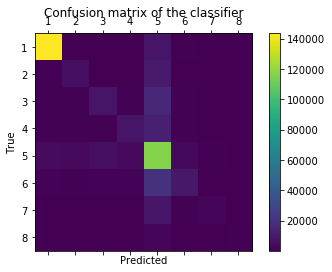

In [26]:
cmForTipClassifiers(pickupWithDummies, pickupDTC, model1Cols)

In [27]:
rfcdfwd = buildTipPredictionModel(pickupDummiesTrain, pickupDummiesTest, model1Cols)

RandomForestClassifier with 10 estimators
has a training score of 0.757076135683
and a test score of 0.60146972836

Features and their importances:

trip_distance: 0.48551523854
weekday_0: 0.00164862382388
weekday_1: 0.00139917239375
payment_type_1: 0.284119140278
payment_type_2: 0.164903827226
payment_type_3: 0.00170082941966
payment_type_4: 0.000584782101901
passenger_count: 0.0354687546868
kmeans_cluster_0: 0.00132680859166
kmeans_cluster_1: 0.00234012199553
kmeans_cluster_2: 0.00140955765122
kmeans_cluster_3: 0.00171227242823
kmeans_cluster_4: 0.00112359975067
kmeans_cluster_5: 0.00250823212291
kmeans_cluster_6: 0.00132862273303
kmeans_cluster_7: 0.00180044613235
kmeans_cluster_8: 0.00141430346478
kmeans_cluster_9: 0.00152017350749
time_of_day_daytime: 0.00195720419907
time_of_day_evening_rush: 0.0017158848225
time_of_day_morning rush: 0.00226396641623
time_of_day_night: 0.002238437714


[[141738    389    593    624   9337   1000    254    121]
 [   400   4121    580    552  11258    704    184     46]
 [   520    575   6419    847  17701   1105    313     79]
 [   588    502    796   7238  13541   1108    328     87]
 [  2436   2170   3751   3119 118926   5148   1568    502]
 [   790    622   1084   1007  20295  10485    534    291]
 [   300    231    394    396   8728    922   2987    146]
 [   150     30    114    130   2767    637    118   1161]]


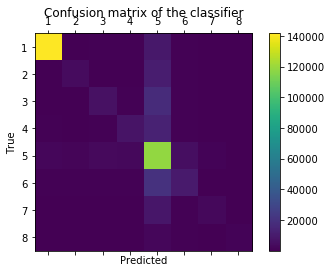

In [28]:
cmForTipClassifiers(pickupWithDummies, rfcdfwd, model1Cols)

As one can see here, the payment type and the trip distance have most importance on the tip given. So now we would like to find out how the score would look like taking into consideration only these columns when building a decision tree.

In [29]:
colsOfInterest = ['trip_distance']
colsOfInterest.extend([col for col in pickupWithDummies.columns if 'payment_type_' in col])

In [30]:
dt2 = buildTipPredictionModel(pickupDummiesTrain, pickupDummiesTest, colsOfInterest, alg='decisionTree')

DecisionTreeClassifier with 5 features
has a training score of 0.663038064232
and a test score of 0.658208750514

Features and their importances:

trip_distance: 0.0506192064104
payment_type_1: 0.949380793016
payment_type_2: 5.73653292041e-10
payment_type_3: 0.0
payment_type_4: 0.0


[[137055     16     59    348  16364    184      4     26]
 [   110    128     50    323  17198     35      1      0]
 [   131     39    257    519  26532     77      0      4]
 [   399    104    169   1804  21601    106      2      3]
 [   430    119    222   1329 134995    474      9     42]
 [   164     52     77    502  33687    580      4     42]
 [    51     20     41    147  13647    162     15     21]
 [    53      7      8     44   4746    200      2     47]]


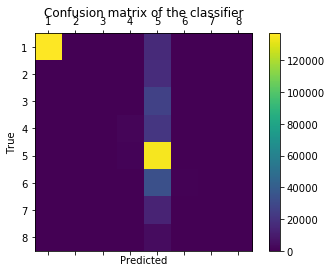

In [31]:
cmForTipClassifiers(pickupWithDummies, dt2, colsOfInterest)

In [32]:
rfc2 = buildTipPredictionModel(pickupDummiesTrain, pickupDummiesTest, colsOfInterest)

RandomForestClassifier with 10 estimators
has a training score of 0.662770972143
and a test score of 0.658360343322

Features and their importances:

trip_distance: 0.137268237961
payment_type_1: 0.38205631465
payment_type_2: 0.475790271854
payment_type_3: 0.00366158609927
payment_type_4: 0.00122358943646


[[136980     21     44    324  16430    211     13     33]
 [    94     87     34    310  17257     55      5      3]
 [   102     26    174    469  26653    119     11      5]
 [   336     65    101   1624  21847    181     29      5]
 [   361     73    142   1155 135197    587     49     56]
 [   128     33     46    443  33719    665     20     54]
 [    37     12     30    135  13646    171     43     30]
 [    48      3      9     31   4741    215      2     58]]


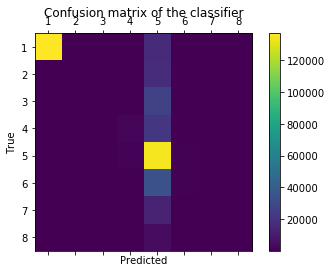

In [33]:
cmForTipClassifiers(pickupWithDummies, rfc2, colsOfInterest)

In [34]:
#dot_data = tree.export_graphviz(dt2, out_file=None)  

#graph = graphviz.Source(dot_data)

#graph.view()

This one is unfortunately not working
import pydotplus
dt_graphviz = tree.export_graphviz(dt2, out_file = None)

pydot_graph = pydotplus.graph_from_dot_data(dt_graphviz)
from IPython.display import Image

Image(pydot_graph.create_png())

Looking at the scores, this model seems not to be overfitted, but it is not too good either...

Prediction:

In [35]:
pdf1 = pickupWithDummies.head(1)

In [36]:
pred = rfcdfwd.predict(pdf1[model1Cols])
print(rfcdfwd.decision_path(pdf1[model1Cols]))

(<1x823866 sparse matrix of type '<class 'numpy.int64'>'
	with 216 stored elements in Compressed Sparse Row format>, array([     0,  82107, 165266, 246985, 329864, 411983, 494680, 577933,
       659888, 741843, 823866]))


In [37]:
def getCountsFromDF(df):
    df['count'] = 1
    countDF = pd.DataFrame.groupby(df,by=['date', 'min_since_midnight_group', 'kmeans_cluster']).sum()
    countDF = countDF.reset_index()
    columns = ['date', 'min_since_midnight_group', 'kmeans_cluster', 'count']
    countDF = countDF[columns]
    return countDF

In [38]:
countPickupDF = getCountsFromDF(pickupDF)

[]

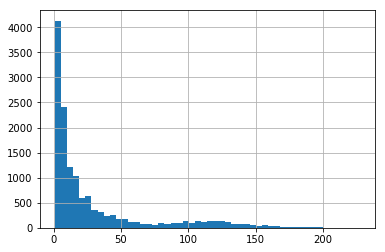

In [39]:
countPickupDF['count'].hist(bins=50).plot()

In [40]:
countPickupDF.head()

,date,min_since_midnight_group,kmeans_cluster,count
0,2016-06-01,30,0,20
1,2016-06-01,30,1,37
2,2016-06-01,30,2,18
3,2016-06-01,30,3,20
4,2016-06-01,30,4,17


In [41]:
countPickupDF["date;min_since_midnight"] = countPickupDF["date"].map(str) +';'+ countPickupDF["min_since_midnight_group"].map(str)

In [42]:
countPickupDF.head(12)

,date,min_since_midnight_group,kmeans_cluster,count,date;min_since_midnight
0,2016-06-01,30,0,20,2016-06-01;30
1,2016-06-01,30,1,37,2016-06-01;30
2,2016-06-01,30,2,18,2016-06-01;30
3,2016-06-01,30,3,20,2016-06-01;30
4,2016-06-01,30,4,17,2016-06-01;30
5,2016-06-01,30,5,52,2016-06-01;30
6,2016-06-01,30,6,13,2016-06-01;30
7,2016-06-01,30,7,12,2016-06-01;30
8,2016-06-01,30,8,12,2016-06-01;30
9,2016-06-01,30,9,9,2016-06-01;30


In [43]:
def buildDataFramesForClusterDF(df):
    # dictionary for clusters
    pickups_brooklyn_clusters = {}
    date = {}
    min_since_midnight = {}
    count = {}
    d = {}
    dft = {}
    for c in range(0, 10):
        pickups_brooklyn_clusters[c] = df[df['kmeans_cluster'] == c]
        date[c] = pickups_brooklyn_clusters[c]['date'].values
        min_since_midnight[c] = pickups_brooklyn_clusters[c]['min_since_midnight_group'].values
        count[c] = pickups_brooklyn_clusters[c]['count'].values
        d = {'date': date[c], 'min_since_midnight': min_since_midnight[c], 'count': count[c]}
        dft[c] = pd.DataFrame(d)
    
    mergedft = pd.merge(dft[0], dft[1], on=['date', 'min_since_midnight'], how='inner', suffixes=('_0', '_1'))
    
    for c in range(2, 10):
        mergedft = pd.merge(mergedft, dft[c], on=['date', 'min_since_midnight'], how='inner', suffixes=('', '_'+str(c)))
    mergedft = mergedft.rename(columns={'count': 'count_2'})

    return dft, mergedft

In [44]:
pickupCountDict, mergedPickupCountClusters = buildDataFramesForClusterDF(countPickupDF)

In [45]:
mergedPickupCountClusters.head()

,count_0,date,min_since_midnight,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9
0,20,2016-06-01,30,37,18,20,17,52,13,12,12,9
1,12,2016-06-01,60,22,27,20,21,34,16,4,10,10
2,18,2016-06-01,90,19,15,16,19,28,11,5,10,6
3,6,2016-06-01,120,17,12,6,12,27,10,5,7,4
4,12,2016-06-01,150,14,10,11,7,16,5,5,5,3


In [46]:
def plots(input_df, k):
    
    fig = plt.figure(figsize=(10, 10))
    
    # histogram
    ax1 = fig.add_subplot(221)
    input_df['count'].hist(bins=25)
    plt.ylabel('frequency')
    plt.xlabel('#pickups')
    plt.title('Histogram of pickup counts in area '+str(k))

    # scatterplot with colours

    ax3 = fig.add_subplot(222)
    ax3.scatter(range(len(input_df['count'])), input_df['count'], c=input_df['min_since_midnight'], s=10)
    plt.title('Pickup counts coloured according to minutes passed in area '+str(k))

    # plot with mean and quantiles 
    df_grouped = input_df.groupby('min_since_midnight').sum()
    df_grouped['means'] = input_df.groupby('min_since_midnight').mean()
    df_grouped['quantile_5'] = input_df.groupby('min_since_midnight').quantile(0.05)
    df_grouped['quantile_95'] = input_df.groupby('min_since_midnight').quantile(0.95)

    x = df_grouped.index
    
    ax4 = fig.add_subplot(223)
    ax4.plot(x, df_grouped.means, c='pink')
    ax4.plot(x, df_grouped.quantile_5, c='green')
    ax4.plot(x, df_grouped.quantile_95, c='orange')
    plt.xlabel('minutes since midnight')
    plt.ylabel('# pickups')
    plt.title('Average, percentile 5 and percentile 95 pickups on a day in area '+str(k))
    plt.legend()

In [47]:
list(pickupCountDict.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

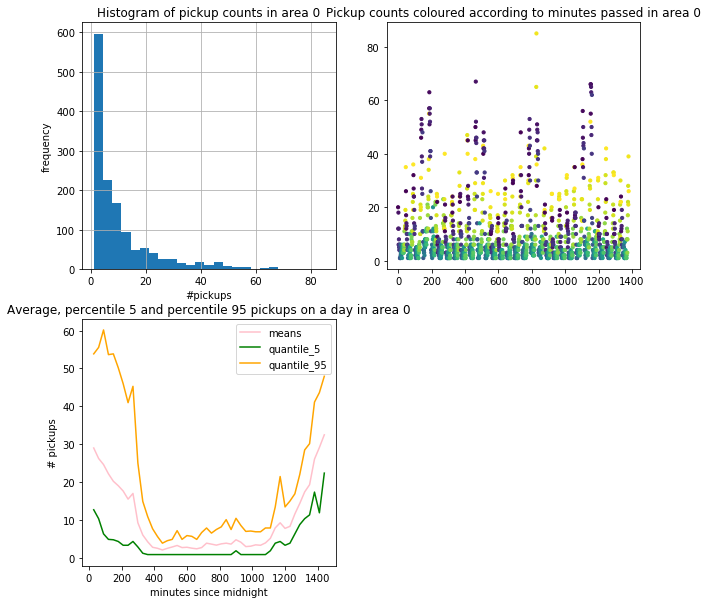

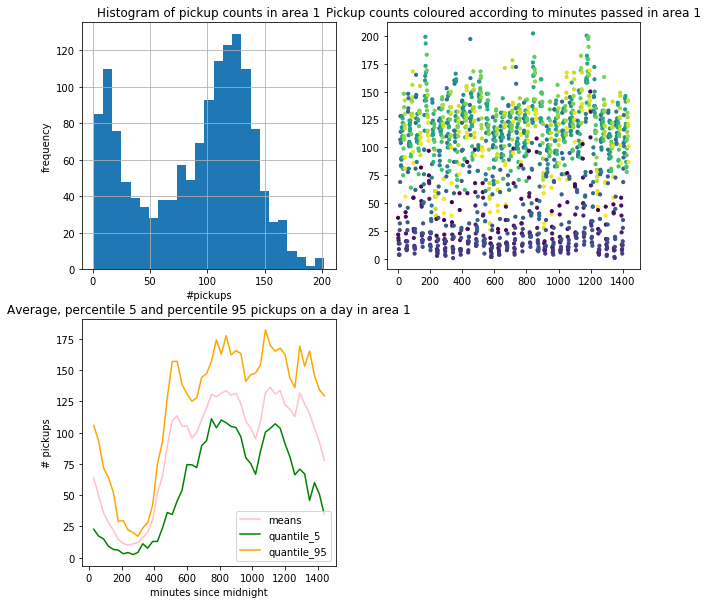

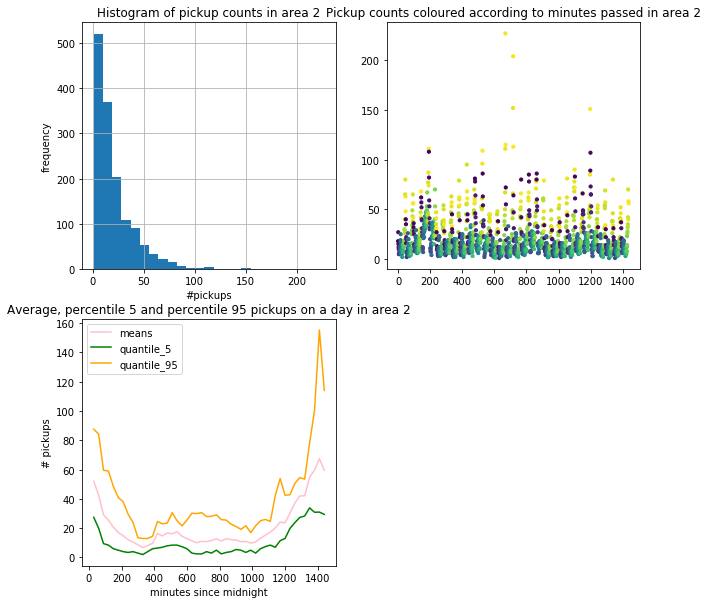

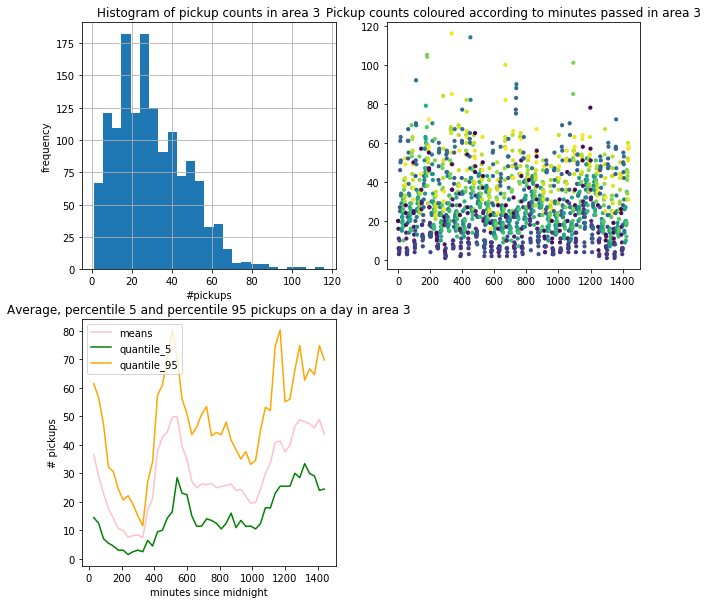

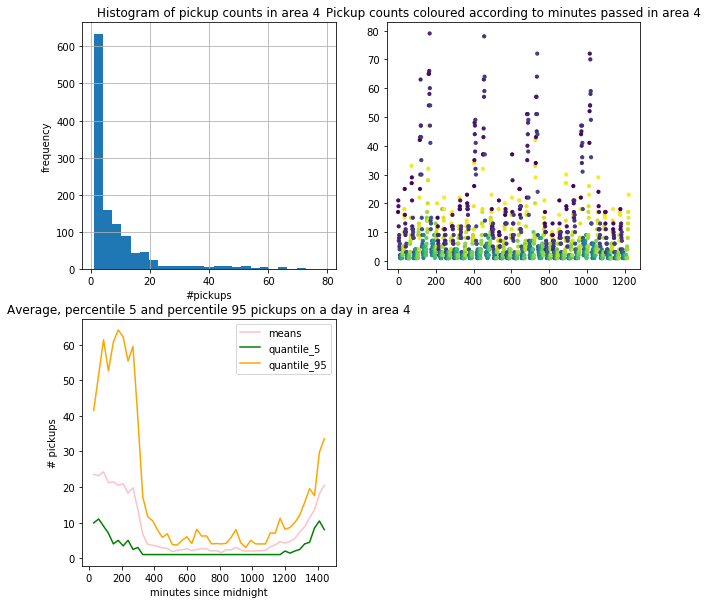

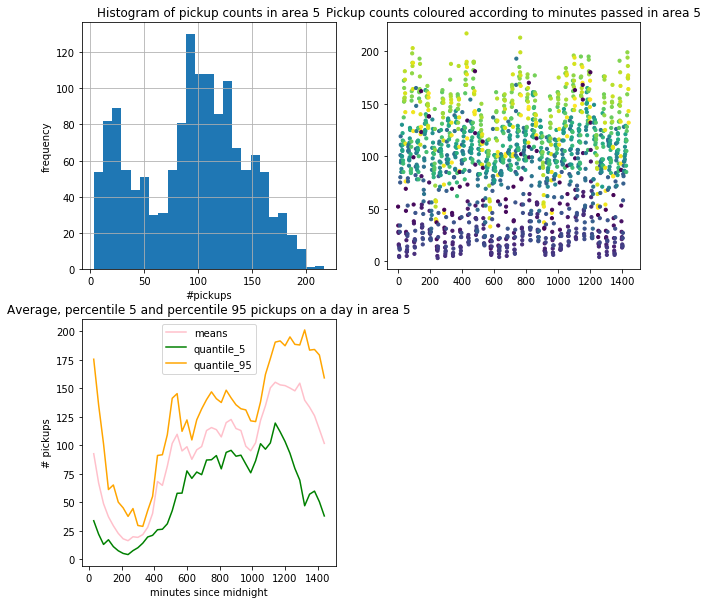

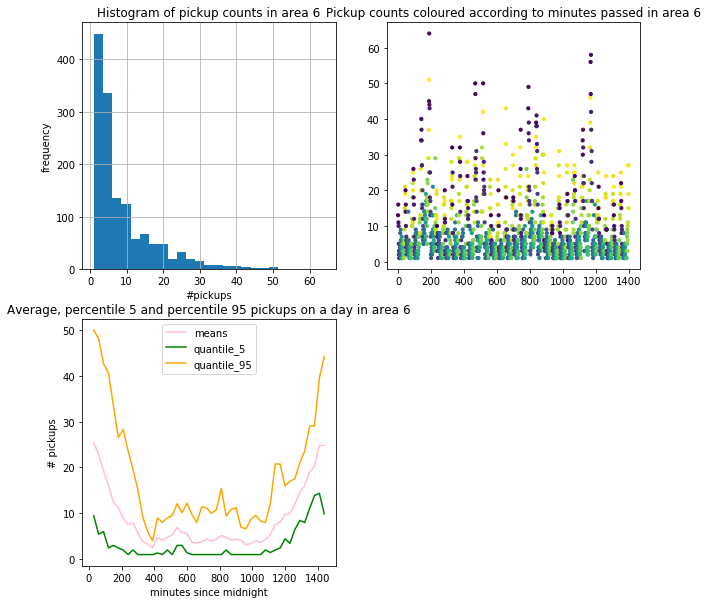

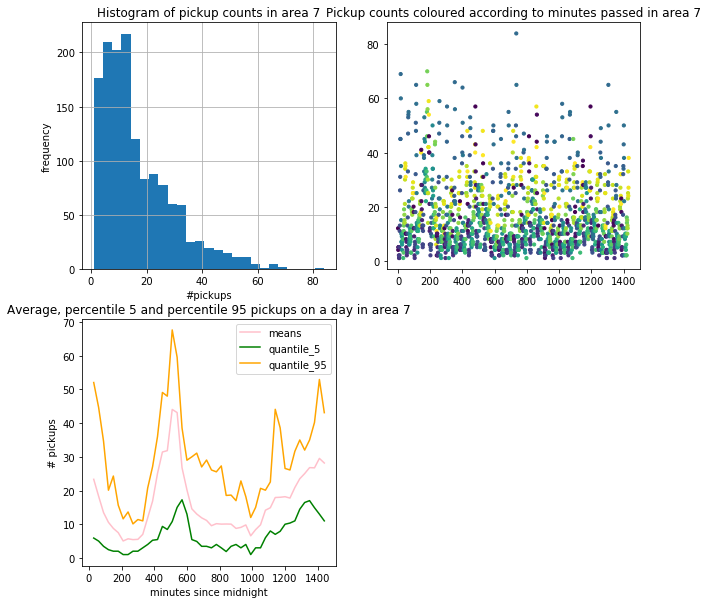

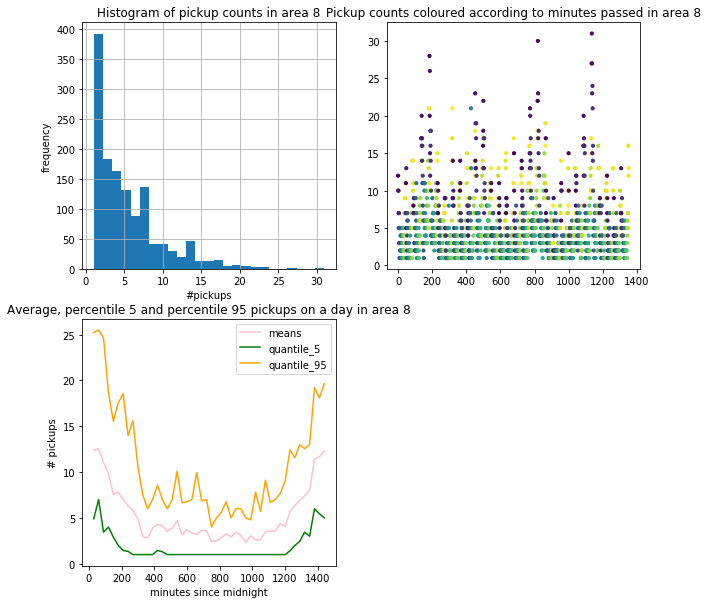

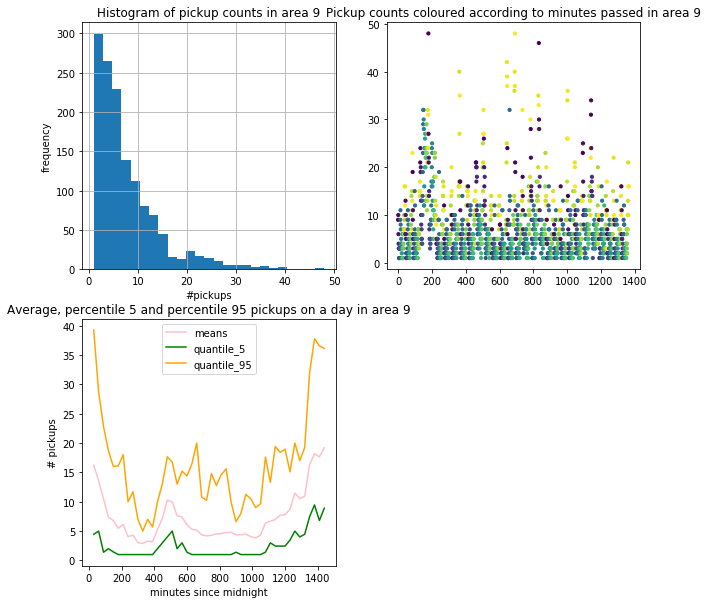

In [48]:
for k in list(pickupCountDict.keys()):
    plots(pickupCountDict[k], k)

In [49]:
def convertMinToTime(minutesDelta):
    if minutesDelta == 1440:
        return dt.time(0, 0)
    else:
        hours = minutesDelta //60
        minutes = minutesDelta % 60
        return dt.time(hours, minutes)


In [50]:
def recombinedDatetimeCol(df):
    df['timetime'] = df['min_since_midnight'].apply(lambda x: convertMinToTime(x))
    df['datetime'] = [dt.datetime.combine(d, t) for d, t in zip(df['date'], df['timetime'])]
    del df['min_since_midnight']
    del df['date']
    df = df.set_index('datetime')
    return df

In [51]:
mergedPickupCountClustersRecombinedDT = recombinedDatetimeCol(mergedPickupCountClusters.copy())

In [52]:
# todo: fix x and y labels
def draw_correlation_matrix(corrDf):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 15)
    cax = ax1.imshow(corrDf, interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation between pickup areas')
    labels=list(corrDf.columns)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax1.set_xticklabels(labels,fontsize=5)
    ax1.set_yticklabels(labels,fontsize=8)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.1,.2,.3,.4,.5, .6,.7, .8,.90,1])
    plt.show()

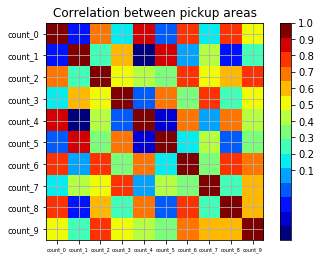

In [53]:
corrDF = mergedPickupCountClustersRecombinedDT.corr()
draw_correlation_matrix(corrDF)

In [54]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 